In [1]:
from torchvision import datasets
import torch
data_folder = '/content/' # This can be any directory you want to download FMNIST to
fmnist = datasets.FashionMNIST(data_folder, download=True, train=True)


Extracting /content/FashionMNIST/raw/train-images-idx3-ubyte.gz to /content/FashionMNIST/raw




Extracting /content/FashionMNIST/raw/train-labels-idx1-ubyte.gz to /content/FashionMNIST/raw




Extracting /content/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to /content/FashionMNIST/raw




Extracting /content/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to /content/FashionMNIST/raw

Processing...
Done!


/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:502: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:143.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


In [2]:


tr_images = fmnist.data
tr_targets = fmnist.targets

In [3]:
val_fmnist = datasets.FashionMNIST(data_folder,download=True,train=False)
val_images = val_fmnist.data
val_targets = val_fmnist.targets

In [4]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
from torch.utils.data import Dataset,DataLoader
import torch
import torch.nn as nn
device = 'cuda' if torch.cuda.is_available() else 'gpu'


# **With out batch Normalization**

So far, when we had to scale input data, we scaled it to a value between 0 and 1. In this section, we will scale it further to a value between 0 and 0.0001 so that we can understand the impact of scaling data. As we saw at the beginning of this section, small input values could not change the Sigmoid value, even with a big variation in weight values

Note that in the bold section of code (x = x.float()/(255*10000)), we have reduced the range of input pixel values by dividing them by 10,000.

Next, we must redefine the get_model function so that we can fetch the model's prediction, as well as the values for the hidden layer. We can do this by specifying a neural network class, as follows

In [5]:
class FMNISTDataset(Dataset):
    def __init__(self, x, y):
        x = x.float()/(255*10000)
        x = x.view(-1,28*28)
        self.x, self.y = x, y 
    def __getitem__(self, ix):
        x, y = self.x[ix], self.y[ix]        
        return x.to(device), y.to(device)
    def __len__(self): 
        return len(self.x)

from torch.optim import SGD, Adam
def get_model():
    class neuralnet(nn.Module):
        def __init__(self):
            super().__init__()
            self.input_to_hidden_layer = nn.Linear(784,1000)
            self.hidden_layer_activation = nn.ReLU()
            self.hidden_to_output_layer = nn.Linear(1000,10)
        def forward(self, x):
            x = self.input_to_hidden_layer(x)
            x1 = self.hidden_layer_activation(x)
            x2= self.hidden_to_output_layer(x1)
            return x2, x1
    model = neuralnet().to(device)

    loss_fn = nn.CrossEntropyLoss()
    optimizer = Adam(model.parameters(), lr=1e-3)
    return model, loss_fn, optimizer

def train_batch(x, y, model, opt, loss_fn):
    prediction = model(x)[0]
    batch_loss = loss_fn(prediction, y)
    batch_loss.backward()
    optimizer.step()
    optimizer.zero_grad()
    return batch_loss.item()

def accuracy(x, y, model):
    with torch.no_grad():
        prediction = model(x)[0]
    max_values, argmaxes = prediction.max(-1)
    is_correct = argmaxes == y
    return is_correct.cpu().numpy().tolist()

In [6]:
def get_data():
    train = FMNISTDataset(tr_images,tr_targets)
    trn_dl = DataLoader(train,batch_size=32,shuffle=True)
    val = FMNISTDataset(val_images,val_targets)
    val_dl = DataLoader(val,batch_size=len(val_images),shuffle=False)
    return trn_dl,val_dl

In [7]:
@torch.no_grad()
def val_loss(x,y,model):
    prediction =model(x)[0]
    val_loss = loss_fn(prediction,y)
    return val_loss.item()

In [8]:
trn_dl,val_dl = get_data()
model,loss_fn,optimizer =get_model()

In [11]:
train_losses, train_accuracies = [], []
val_losses, val_accuracies = [], []
for epoch in range(100):
    print(epoch)
    train_epoch_losses, train_epoch_accuracies = [], []
    for ix, batch in enumerate(iter(trn_dl)):
        x, y = batch
        batch_loss = train_batch(x, y, model, optimizer, loss_fn)
        train_epoch_losses.append(batch_loss)        
    train_epoch_loss = np.array(train_epoch_losses).mean()

    for ix, batch in enumerate(iter(trn_dl)):
        x, y = batch
        is_correct = accuracy(x, y, model)
        train_epoch_accuracies.extend(is_correct)
    train_epoch_accuracy = np.mean(train_epoch_accuracies)

    for ix, batch in enumerate(iter(val_dl)):
        x, y = batch
        val_is_correct = accuracy(x, y, model)
        validation_loss = val_loss(x, y, model)
    val_epoch_accuracy = np.mean(val_is_correct)

    train_losses.append(train_epoch_loss)
    train_accuracies.append(train_epoch_accuracy)
    val_losses.append(validation_loss)
    val_accuracies.append(val_epoch_accuracy)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99


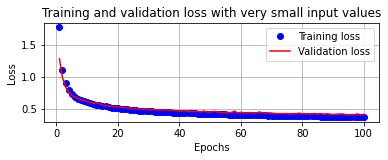

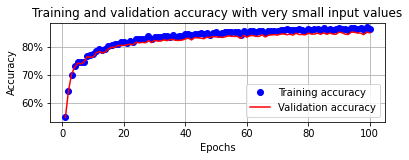

In [10]:
epochs = np.arange(100)+1
import matplotlib.ticker as mtick
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
%matplotlib inline
plt.subplot(211)
plt.plot(epochs, train_losses, 'bo', label='Training loss')
plt.plot(epochs, val_losses, 'r', label='Validation loss')
#plt.gca().xaxis.set_major_locator(mticker.MultipleLocator(1))
plt.title('Training and validation loss with very small input values')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid('off')
plt.show()
plt.subplot(212)
plt.plot(epochs, train_accuracies, 'bo', label='Training accuracy')
plt.plot(epochs, val_accuracies, 'r', label='Validation accuracy')
#plt.gca().xaxis.set_major_locator(mticker.MultipleLocator(1))
plt.title('Training and validation accuracy with very small input values')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
#plt.ylim(0.8,1)
plt.gca().set_yticklabels(['{:.0f}%'.format(x*100) for x in plt.gca().get_yticks()]) 
plt.legend()
plt.grid('off')
plt.show()

Text(0.5, 1.0, "Hidden layer node values' distribution with batch normalization")

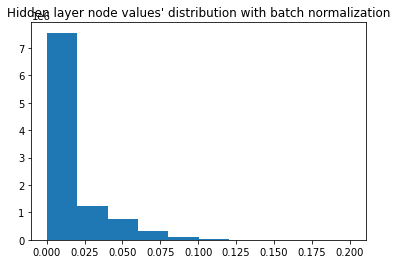

In [14]:
plt.hist(model(x)[1].cpu().detach().numpy().flatten())
plt.title("Hidden layer node values' distribution with batch normalization")

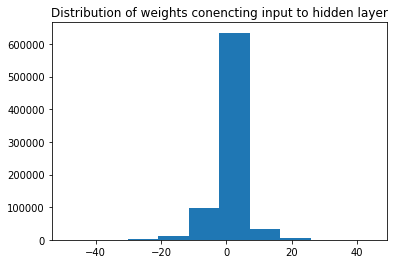

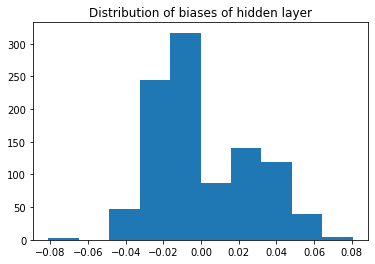

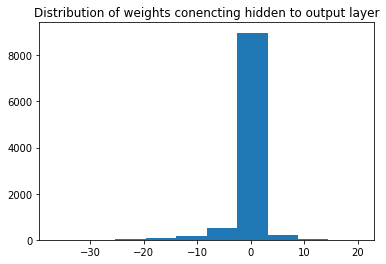

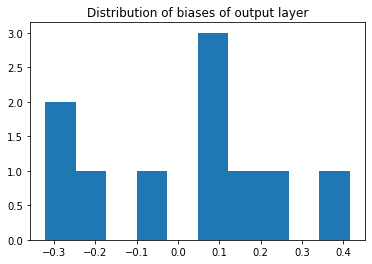

In [15]:
for ix, par in enumerate(model.parameters()):
  if(ix==0):
      plt.hist(par.cpu().detach().numpy().flatten())
      #plt.xlim(-2,2)
      plt.title('Distribution of weights conencting input to hidden layer')
      plt.show()
  elif(ix ==1):
      plt.hist(par.cpu().detach().numpy().flatten())
      #plt.xlim(-2,2)
      plt.title('Distribution of biases of hidden layer')
      plt.show()
  elif(ix==2):
      plt.hist(par.cpu().detach().numpy().flatten())
      #plt.xlim(-2,2)
      plt.title('Distribution of weights conencting hidden to output layer')
      plt.show()
  elif(ix ==3):
      plt.hist(par.cpu().detach().numpy().flatten())
      #plt.xlim(-2,2)
      plt.title('Distribution of biases of output layer')
      plt.show()

# **Very small input values with batch normalization**

1.   In this section, we'll only be making one change to the code from the previous subsection; that is, we'll be adding batch normalization while defining the model architecture.The modified get_model function is as follows:


2.   Note that in the preceding code, we declared a variable (batch_norm) that performs batch normalization (nn.BatchNorm1d). The reason we are performing nn.BatchNorm1d(1000) is because the output dimension is 1,000 for each image (that is, a 1-dimensional output for the hidden layer). 



In [30]:
class FMNISTDataset(Dataset):
    def __init__(self,x,y):
        x = x.float()/(255/10000)
        x  = x.view(-1,28*28)
        self.x,self.y=x,y
    def __getitem__(self,ix):
        x,y = self.x[ix],self.y[ix]
        return x.to(device),y.to(device)
    def __len__(self):
        return len(self.x)

from torch.optim import SGD,Adam
def get_model():
    class neuralnet(nn.Module):
        def __init__(self):
            super().__init__()
            self.input_to_hidden_layer=nn.Linear(784,1000)
            self.batch_norm = nn.BatchNorm1d(1000)
            self.hidden_layer_activation= nn.ReLU()
            self.hidden_to_output_layer =nn.Linear(1000,10)
        def forward(self, x):
            x = self.input_to_hidden_layer(x)
            x0 = self.batch_norm(x)
            x1 = self.hidden_layer_activation(x0)
            x2= self.hidden_to_output_layer(x1)
            return x2, x1
    model = neuralnet().to(device)
    loss_fn = nn.CrossEntropyLoss()
    optimizer = Adam(model.parameters(), lr=1e-3)
    return model, loss_fn, optimizer

def train_batch(x, y, model, opt, loss_fn):
    prediction = model(x)[0]
    batch_loss = loss_fn(prediction, y)
    batch_loss.backward()
    optimizer.step()
    optimizer.zero_grad()
    return batch_loss.item()

def accuracy(x, y, model):
    with torch.no_grad():
        prediction = model(x)[0]
    max_values, argmaxes = prediction.max(-1)
    is_correct = argmaxes == y
    return is_correct.cpu().numpy().tolist()

In [31]:

def val_loss(x, y, model):
    with torch.no_grad():
        prediction = model(x)[0]
    val_loss = loss_fn(prediction, y)
    return val_loss.item()

In [32]:
trn_dl, val_dl = get_data()
model, loss_fn, optimizer = get_model()

In [33]:
train_losses, train_accuracies = [], []
val_losses, val_accuracies = [], []
for epoch in range(100):
    print(epoch)
    train_epoch_losses, train_epoch_accuracies = [], []
    for ix, batch in enumerate(iter(trn_dl)):
        x, y = batch
        batch_loss = train_batch(x, y, model, optimizer, loss_fn)
        train_epoch_losses.append(batch_loss)        
    train_epoch_loss = np.array(train_epoch_losses).mean()

    for ix, batch in enumerate(iter(trn_dl)):
        x, y = batch
        is_correct = accuracy(x, y, model)
        train_epoch_accuracies.extend(is_correct)
    train_epoch_accuracy = np.mean(train_epoch_accuracies)

    for ix, batch in enumerate(iter(val_dl)):
        x, y = batch
        val_is_correct = accuracy(x, y, model)
        validation_loss = val_loss(x, y, model)
    val_epoch_accuracy = np.mean(val_is_correct)

    train_losses.append(train_epoch_loss)
    train_accuracies.append(train_epoch_accuracy)
    val_losses.append(validation_loss)
    val_accuracies.append(val_epoch_accuracy)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99


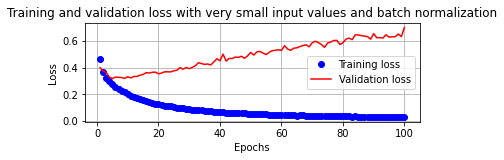

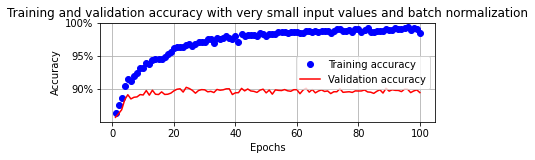

In [34]:
epochs = np.arange(100)+1
import matplotlib.ticker as mtick
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
%matplotlib inline
plt.subplot(211)
plt.plot(epochs, train_losses, 'bo', label='Training loss')
plt.plot(epochs, val_losses, 'r', label='Validation loss')
#plt.gca().xaxis.set_major_locator(mticker.MultipleLocator(1))
plt.title('Training and validation loss with very small input values and batch normalization')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid('off')
plt.show()
plt.subplot(212)
plt.plot(epochs, train_accuracies, 'bo', label='Training accuracy')
plt.plot(epochs, val_accuracies, 'r', label='Validation accuracy')
#plt.gca().xaxis.set_major_locator(mticker.MultipleLocator(1))
plt.title('Training and validation accuracy with very small input values and batch normalization')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
#plt.ylim(0.8,1)
plt.gca().set_yticklabels(['{:.0f}%'.format(x*100) for x in plt.gca().get_yticks()]) 
plt.legend()
plt.grid('off')
plt.show()



*   Here, we can see that the model was trained in a manner very similar to how it was trained when the input values did not have a very small range.
*   Let's understand the distribution of hidden layer values and the weight distribution, as seen in the previous section:



Text(0.5, 1.0, "Hidden layer node values' distribution with batch normalization")

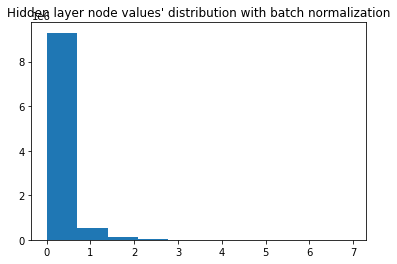

In [35]:
plt.hist(model(x)[1].cpu().detach().numpy().flatten())
plt.title("Hidden layer node values' distribution with batch normalization")

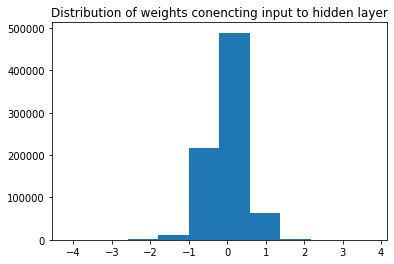

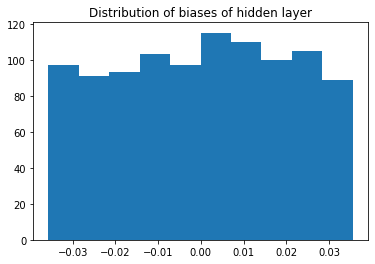

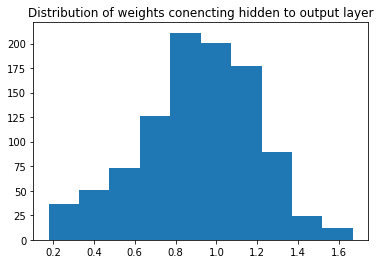

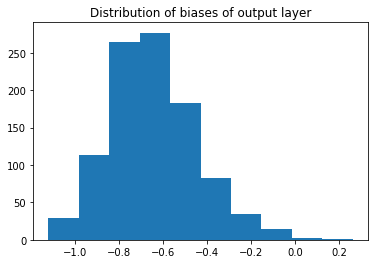

In [36]:
for ix, par in enumerate(model.parameters()):
  if(ix==0):
      plt.hist(par.cpu().detach().numpy().flatten())
      #plt.xlim(-2,2)
      plt.title('Distribution of weights conencting input to hidden layer')
      plt.show()
  elif(ix ==1):
      plt.hist(par.cpu().detach().numpy().flatten())
      #plt.xlim(-2,2)
      plt.title('Distribution of biases of hidden layer')
      plt.show()
  elif(ix==2):
      plt.hist(par.cpu().detach().numpy().flatten())
      #plt.xlim(-2,2)
      plt.title('Distribution of weights conencting hidden to output layer')
      plt.show()
  elif(ix ==3):
      plt.hist(par.cpu().detach().numpy().flatten())
      #plt.xlim(-2,2)
      plt.title('Distribution of biases of output layer')
      plt.show()

Here, we can see that the hidden layer values have a larger distribution when we have batch normalization and that the weights connecting the hidden layer to the output layer have a smaller distribution. The results in the model learning as effectively as it could in the previous sections.

Note that in the preceding scenario, we attained high validation accuracy sooner than when there was no batch normalization at all. This could have been the result of normalizing the intermediate layers, resulting in fewer chances of saturation occurring in the weights. However, the issue of overfitting is yet to be fixed. We will look at this next.